# Population Prediction by Land Use

##### geojson data about Wisconsin census tracts and counties will be read in, cleaned, and analyzed using *SQLite*, *geopandas*, and *matplotlib*. With this newfound data, K-means clustering will be applied to differentiate the types of counties based on land use. Finally, a linear regression model will then be trained to predict an area's population based on its land use types.

### Part I: Collection and Cleaning of Data

In [1]:
import geopandas as gpd

# read in geojson file
gdf = gpd.read_file("counties.geojson")
gdf.head()

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.7246 44.3384..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."


Read in database and convert to SQL using SQLite3

In [2]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
conn = sqlite3.connect("counties_tracts.db")
counties = pd.read_sql("""SELECT * FROM counties""", conn)
tracts = pd.read_sql("""SELECT * FROM tracts""", conn)

In [3]:
gdf['AREALAND'] = counties['AREALAND'] # add column of raw area of the county, as opposed to original geometric coordinate points
gdf.head()

,NAME,POP100,geometry,AREALAND
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.7246 44.3384...",2054044751
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413


Using SQLite, more tables are read in, including individual county and tract data. The datafram now contains land area, water area, and housing units for each county.

In [4]:
# group housing numbers by county from tracts
tracts_df = pd.read_sql("""SELECT county, SUM(HU100) AS HOUSING
FROM tracts
GROUP BY county""", conn)

# convert pd df to sql
tracts_df.to_sql("tracts_df", conn, if_exists="replace", index=False)

# join tracts_df housing column to counties df by county
joined = pd.read_sql("""SELECT counties.*, tracts_df.HOUSING
FROM counties
INNER JOIN tracts_df
ON counties.COUNTY == tracts_df.COUNTY""", conn)

joined.head()

,index,NAME,COUNTY,AREALAND,AREAWATER,HOUSING
0,0,Racine County,101,861533739,1190103013,82164
1,1,Clark County,019,3133378070,23239614,15076
2,2,Wood County,141,2054044751,41994799,34088
3,3,Rusk County,107,2366092584,44813690,8883
4,4,Ozaukee County,089,603514413,2287415379,36267


Add housing data from joined SQL table to gdf:

In [5]:
gdf['HU100'] = joined['HOUSING']

gdf.head()

,NAME,POP100,geometry,AREALAND,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.7246 44.3384...",2054044751,34088
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,8883
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,36267


### Part II: Population Regression Model Using Housing Units

Slope-intercept formula for housing units vs. population

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train, test = train_test_split(gdf, test_size=0.25, random_state=320)

model = LinearRegression()
model.fit(train[['HU100']], train['POP100'])

m = round(float(model.coef_[0]), 2)
b = round(float(model.intercept_), 2)
answer = f'Population = {m} * Housing Units + {b}'
answer

'Population = 2.39 * Housing Units + -7910.46'

In [7]:
# explained variance score between population and housing units
from sklearn.metrics import explained_variance_score

y_true = test[['POP100']]
y_pred = model.predict(test[['HU100']])

score = round(explained_variance_score(y_true, y_pred), 3)
print(f'The explained variance score between population and housing units is very strong ({score}), meaning the model explains {score*100}% of the variance of population based on housing units.')

The explained variance score between population and housing units is very strong (0.996), meaning the model explains 99.6% of the variance of population based on housing units.


The extremely strong linear correlation is shown in a graph:

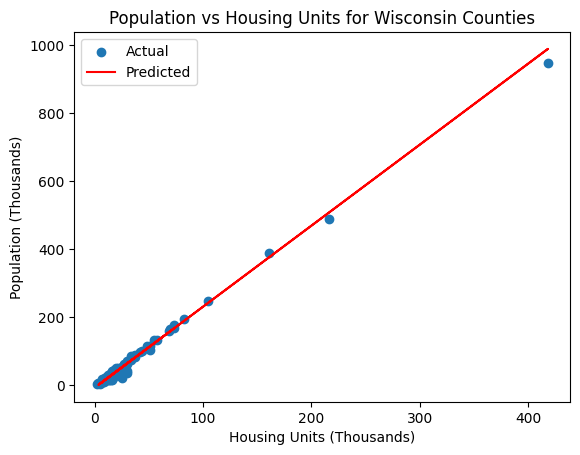

In [8]:
#Q12
plt.scatter(x = gdf['HU100']/1000, y = gdf['POP100']/1000)
plt.xlabel("Housing Units (Thousands)")
plt.ylabel("Population (Thousands)")
plt.title("Population vs Housing Units for Wisconsin Counties")
plt.plot(test['HU100']/1000, y_pred/1000, color="red")
plt.legend(["Actual", "Predicted"])
plt.show()

### Part III: Land Uses and Working with *rasterio*

In [9]:
import rasterio
from rasterio.mask import mask
import numpy as np
from matplotlib.colors import ListedColormap

land = rasterio.open("zip://./land.zip!/wi.tif") # read in zipped TIF file using rasterio

A dictionary will be used to keep track of the numbers associated with each land use. An array is created and the land use numbers from the dict are each given a different color. This will be useful when generating maps.

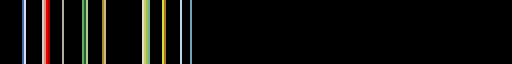

In [10]:
# land_use dict for reference
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

# assign colors to the rows based on the land_use dict labels
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)
custom_cmap

#### **show_county() function**

Will show the map of the Wisconsin county entered as the parameter using the color-coded array and masking the county information over the *land* file:

In [11]:
def show_county(county):

    county_gdf = gdf.loc[gdf.NAME == f'{county} County']

    matrix, _ = mask(land, county_gdf.to_crs(land.crs)['geometry'], crop=True)
    matrix = matrix[0]

    fig, ax = plt.subplots()
    ax.imshow(matrix, vmin=0, vmax = 255, cmap = custom_cmap)
    plt.title(f'{county} County')
    plt.axis('off')
    plt.show()

**Dane County**

The population heavy areas of downtown Madison around the lakes and isthmus are shown in bright red, while the barren grasslands and crop fields, as well as forested areas, take up yellowish-brown and green, respectively.

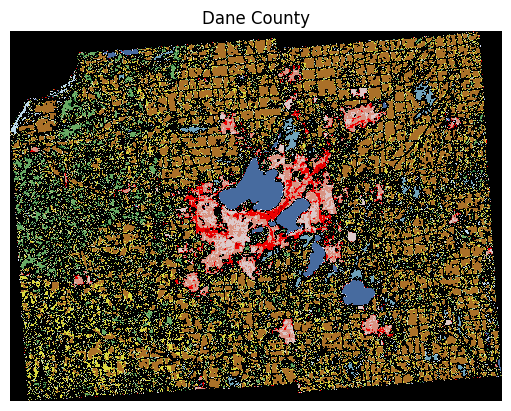

In [12]:
show_county('Dane')

**Milwuakee County & Iowa County**

Here, the contrast of Wisconsin is shown; Milwuakee County is full of highly developed areas with hundreds of thousands of civilians, while Iowa County is almost exclusively farmland and forestation.

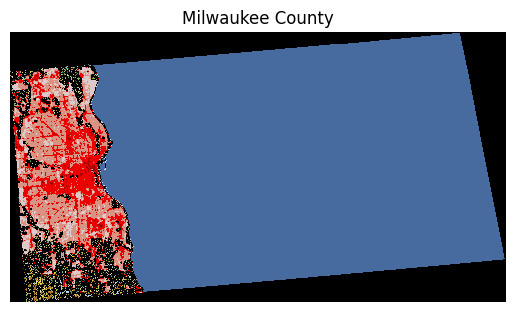

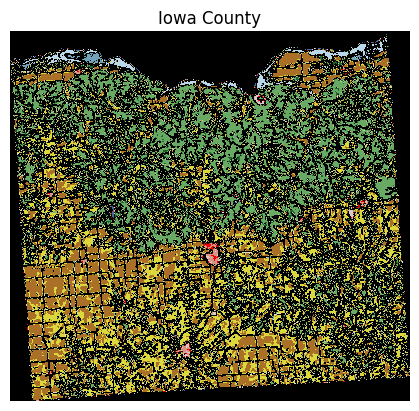

In [13]:
show_county('Milwaukee')
show_county('Iowa')

**Finally, all of the counties in the state:**

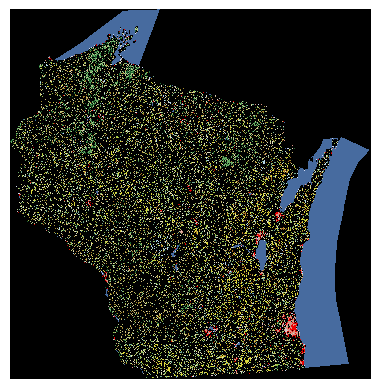

In [14]:
matrix, _ = mask(land, gdf.to_crs(land.crs)['geometry'], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots()
ax.imshow(matrix, vmin=0, vmax = 255, cmap = custom_cmap)
plt.axis('off')
plt.show()

### Part IV: K-Means Clustering of Counties, Maps
By using K-Means clustering, the four types of counties shown below. 

It seems clear that northern Wisconsin is mostly forested, the south-eastern counties are littered with crops, and the greater-Milwaukee area is developed and dense with housing and people. 

The remaining counties appear to have lots of pasture area for livestock, an important factor of Wisconsin's economy.

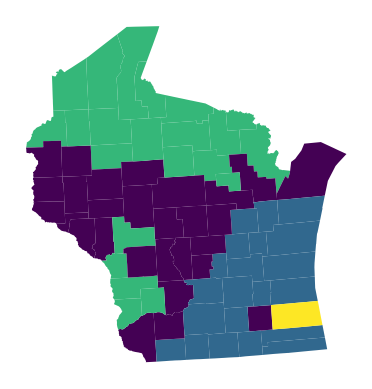

In [15]:
from sklearn.cluster import KMeans

counties_detailed = gpd.read_file('counties_detailed.geojson')

cols = ["developed", "forest", "pasture", "crops"]

# create four clusters from four land uses
km_c = KMeans(4)

km_c.fit(counties_detailed[cols])
clusters = km_c.predict(counties_detailed[cols])

counties_detailed.plot(column=clusters)
plt.axis('off')
plt.show()

The hypotheses above are backed up further by the maps of each individiual variable.

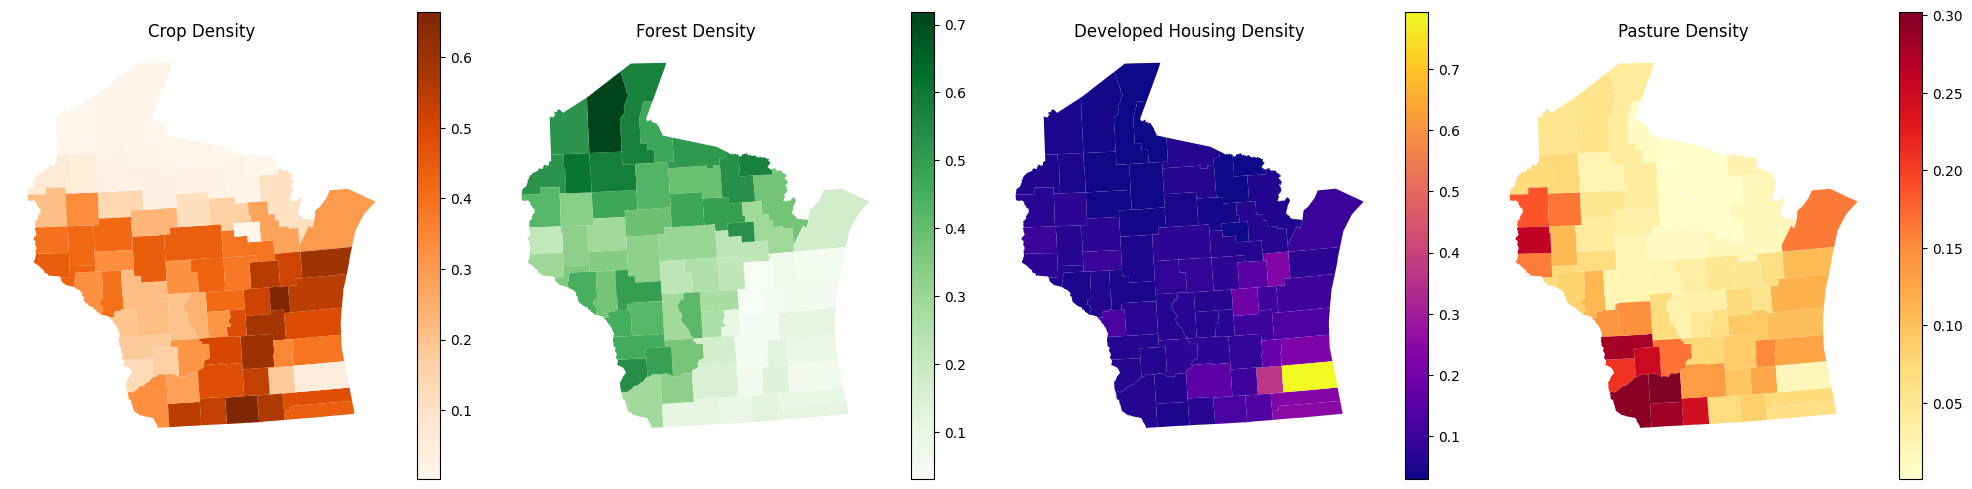

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

counties_detailed.plot(column='crops', legend=True, ax=axes[0], cmap="Oranges")
axes[0].set_title("Crop Density")
axes[0].axis('off')

counties_detailed.plot(column='forest', legend=True, ax=axes[1], cmap='Greens')
axes[1].set_title('Forest Density')
axes[1].axis('off')

counties_detailed.plot(column='developed', legend=True, ax=axes[2], cmap="plasma")
axes[2].set_title('Developed Housing Density')
axes[2].axis('off')

counties_detailed.plot(column='pasture', legend=True, ax=axes[3], cmap='YlOrRd')
axes[3].set_title('Pasture Density')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### Part V: Linear Regression Model to Predict Population Based On Land Use

Now with a better understanding of the differences between Wisconsin counties and areas, a model will be trained to predict the population of any tract given the types of land uses. This could be used for urban planning or policy making for neighborhoods or communities.

First, the columns of land uses must be added to the new tracts dataframe:

In [17]:
tracts = gpd.read_file('tracts.shp')
for key in land_use:
    tracts[key] = 0

Next, the land use amounts are added to the tract dataframe using Rasterio:

In [18]:
for idx, tract in tracts.iterrows():
    df = tracts.loc[[idx]] # creates dataframe for current row
    
    # converts row crs to the land df's crs and uses Rasterio to extract the overlapping position using the coordinates
    matrix, _ = mask(land, df.to_crs(land.crs)['geometry'], crop=True)
    matrix = matrix[0]
    
    # calculates how many square meters of each land use is present in the current tract and adds the number to the tract df
    for use, amt in land_use.items():
        count = int(np.sum(matrix==amt))
        tracts.at[idx, use] = count

tracts.head()

,GEOID,POP100,geometry,open_water,ice_snow,developed_open,developed_low,developed_med,developed_high,barren,...,dwarf_scrub,shrub_scrub,grassland,sedge,lichens,moss,pasture,crops,woody_wetlands,herbacious_wetlands
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02627 44.089...",55465,0,12351,5402,833,104,175,...,0,18518,33652,0,0,0,3136,73433,84766,20975
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.1501 44.5139...",57,0,1456,2104,1211,243,229,...,0,23,38,0,0,0,770,1503,2317,123
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53547 44.334...",2107187,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.89338 44.678...",117008,0,6209,7738,1971,337,718,...,0,60,327,0,0,0,17419,112681,26017,2677
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.05841 44.461...",530,0,1141,2711,1109,174,2,...,0,0,52,0,0,0,23,2,79,47


##### **Potential Variable Coefficients**

There are twenty land use types. By extracting the coefficients of all the land uses, it becomes clear which ones would impact our model the greatest. There are many that have little to no influence, so it makes sense to only include the most important ones to improve model efficiency.

*developed_med* and *developed_high* are the two land uses with the highest magnitude. An increase in *developed_med* has a strong correlation with an increase in population, while *developed_high* has a strong correlation with a decrease in population. The other less strong but notable variables include *developed_open*, *developed_low*, *barren*, and *grassland*. 

It is most efficient to only use those variables in the model because they are the ones that will affect the predicted value the greatest.

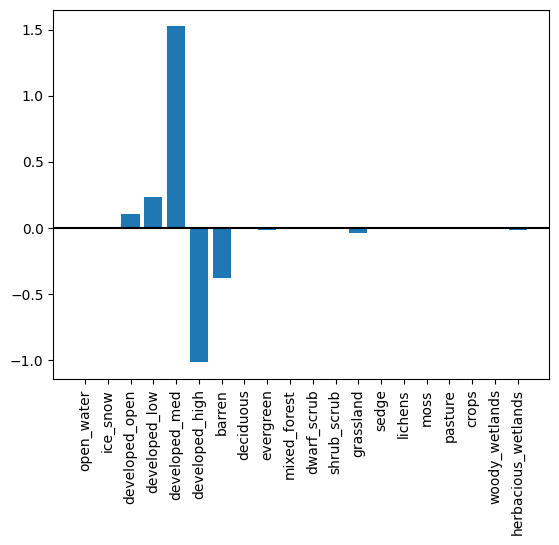

In [19]:
model = LinearRegression()

types = list(land_use.keys())
x = tracts[types]
y = tracts['POP100']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = 320)

model.fit(X_train, Y_train)
plt.bar(types, model.coef_)
plt.xticks(rotation=90)
plt.axhline(y=0, color='black')  # Add horizontal line at y = 0
plt.show()

By isolating the impactful variables, it becomes clearer the effect each one will have on the model:

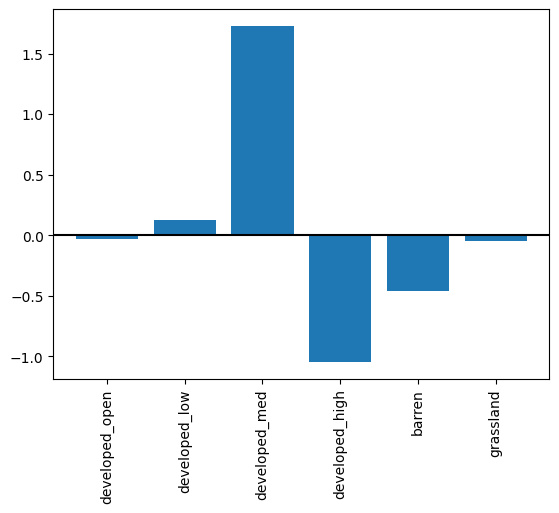

In [20]:
variables = ['developed_open', 'developed_low', 'developed_med', 'developed_high', 'barren', 'grassland']

model = LinearRegression()

x = tracts[variables]
y = tracts['POP100']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = 320)
model.fit(X_train, Y_train)

plt.bar(variables, model.coef_)
plt.xticks(rotation=90)
plt.axhline(y=0, color='black')  # Add horizontal line at y = 0
plt.show()

#### **get_population() Function**
This function takes in six paramaters - the variables found above to have the greatest coefficients - and plugs the values into the linear regression model to estimate the population of any land area based on the type of usage.

In [21]:
def get_population(developed_open, developed_low, developed_med, developed_high, barren, grassland):

    predict_df = pd.DataFrame({"developed_open": [developed_open], "developed_low": [developed_low], "developed_med": [developed_med], "developed_high": [developed_high], "barren": [barren], 
                               "grassland": [grassland]})
    population = int(model.predict(predict_df)[0])

    return f'The projected population of this area would be {population}.'

# example:
get_population(1000, 500, 250, 800, 300, 400)

'The projected population of this area would be 1747.'

#### **Model Performance Metrics**

By iterating through random states and finding the average cross-val and explained vairance scores, a clearer picture of the model's accuracy is unveiled:

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


model = LinearRegression()

x = tracts[variables]
y = tracts['POP100']

averages = []
std_devs = []
exp_vars = []

for i in range(10): # iterate through random states to get more accurate overall scores

    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = i)
    model_scores = cross_val_score(model, X_train, Y_train)

    # add iteration score to lists
    averages.append(float(model_scores.mean()))
    std_devs.append(float(model_scores.std()))

    model.fit(X_train, Y_train)
    predict = model.predict(X_test)

    exp_vars.append(explained_variance_score(Y_test, predict))

# find averages of all ten scores for random states 0-9
model_avg = round(np.average(averages), 2)
model_std = round(np.average(std_devs), 2)
model_exp_var = round(np.average(exp_vars), 2)

print(f'The model has an average cross-validation score of {model_avg} and an average cross-validation standard deviation of {model_std}. The explained variance score is {model_exp_var}.')

The model has an average cross-validation score of 0.44 and an average cross-validation standard deviation of 0.04. The explained variance score is 0.44.


#### **Mean Absolute Error & Root Mean Squared Error**

The Root Mean Squared Error being larger than the Mean Absolute Error signifies that the model contains large outliers. 

These are likely the tracts of Milwuakee County and Dane County; highly-populated developed areas that contrast the rural farmland and forested areas.

In [23]:
mae = round(float(mean_absolute_error(Y_test, predict)))
rmse = round(float(np.sqrt(mean_squared_error(Y_test, predict))))

print(f'The Mean Absolute Error of the model is {mae} and the Root Mean Squared Error is {rmse}. The average predicted value is {round(np.average(Y_test))}.')

The Mean Absolute Error of the model is 910 and the Root Mean Squared Error is 1164. The average predicted value is 3904.


#### **Actual vs Predicted Population Scatter Plot**

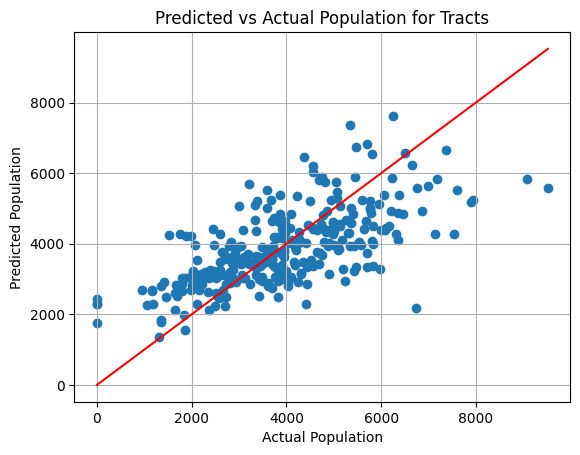

In [24]:
plt.scatter(Y_test, predict)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='-')
plt.title('Predicted vs Actual Population for Tracts')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.grid(True)
plt.show()

#### **Residual Plot**
After analyzing the residual plot, it appears the model slightly overestimates the population at higher levels. Other than that, the plot indicates linearity, there is no clear structure or pattern of the residual points:

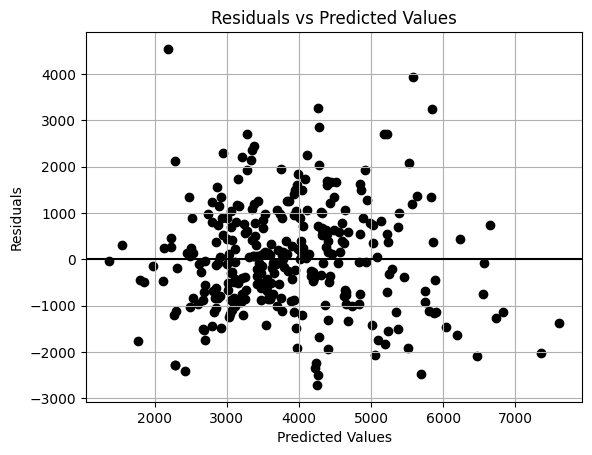

In [25]:
residuals = Y_test - predict

# Plot
plt.scatter(predict, residuals, c='Black')
plt.axhline(0, color='red', linestyle='-', c='Black')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

## Concluding Thoughts

While the model only has moderate accuracy, it is quite simplistic and more fine-tuning could improve the quality. The model would likely be used to serve as a rough estimate instead of a precise projection. The accuracy would improve if counties were used instead of tracts, but the specificity of the smaller areas would be important for urban planning for potential communities or neighborhoods. The extreme outliers tracts of Milwuakee County and Dane County make it hard to translate the projection onto smaller rural areas with less developed land, as shown by a higher RMSE than MAE. It would be interesting to test the models on different states with different climates, geography, and population densities than Wisconsin. On a personal note, this was a fun and educating project that deepened my understanding of regression and K-means clustering, and the processes behind the models.